## Data Cleaning Stage

### Data reading

This notebook brings uses the scripts read_data_features.py and read_data_genre_track.py to arrive at a cleaned dataset with ready to use features and labels.

The following is 'read_data_genre_track.py'. 

In [1]:
import numpy as np
import pandas as pd

In [2]:
import xgboost as xgb
import itertools
import pickle
import matplotlib
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.utils.class_weight import compute_class_weight
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, roc_auc_score, roc_curve, auc
from scipy import interp
from itertools import cycle

#matplotlib.rcParams.update({'font.size': 14})
%matplotlib inline

In [3]:
metadata_path = '..\\Dataset\\fma_metadata'

In [4]:
## Read genre information
genres = pd.read_csv(metadata_path+'\\genres.csv')

In [5]:
genre_grps = genres.groupby('parent')


In [6]:
genre_id_root = genre_grps.get_group(0)['genre_id'] # Extract the parent groups
genre_id_name = genre_grps.get_group(0)['title']
main_label_dict = dict(zip(list(genre_id_root),list(genre_id_name)))

In [7]:
main_label_dict

{2: 'International',
 3: 'Blues',
 4: 'Jazz',
 5: 'Classical',
 8: 'Old-Time / Historic',
 9: 'Country',
 10: 'Pop',
 12: 'Rock',
 13: 'Easy Listening',
 14: 'Soul-RnB',
 15: 'Electronic',
 17: 'Folk',
 20: 'Spoken',
 21: 'Hip-Hop',
 38: 'Experimental',
 1235: 'Instrumental'}

In [8]:
## Read track information
fields = ['track']
tracks = pd.read_csv(metadata_path+'\\tracks_mod.csv',nrows=85000)
tracks.head()

,track_id,genres,genres_all
0,2,[21],[21]
1,3,[21],[21]
2,5,[21],[21]
3,10,[10],[10]
4,20,"[76, 103]","[17, 10, 76, 103]"


In [9]:
tracks = tracks.dropna()

In [10]:
tgen = list(tracks['genres'])
#print(tgen)

In [11]:
tgen = [t.replace('[','') for t in tgen]
tgen = [t.replace(']','') for t in tgen]
tgen = [t.replace(' ','') for t in tgen]
#print(tgen)

In [12]:
for k in range(len(tgen)):
    if(len(tgen[k])!=0):
        tgen[k] = [i for i in map(int, tgen[k].split(','))]
    else:
        tgen[k]=[]
#print(tgen)

In [13]:
tracks['genres']=tgen

In [14]:
tracks.head()

,track_id,genres,genres_all
0,2,[21],[21]
1,3,[21],[21]
2,5,[21],[21]
3,10,[10],[10]
4,20,"[76, 103]","[17, 10, 76, 103]"


In [15]:
print(len(tgen))
#print(tracks.index)

84991


### Extracting relevant tracks and labels

In [16]:
## Match the tracks to the genre data: Create dictionary with genre label as key
genre_dict = {}
for i in range(len(tgen)): # for every track (tgen is a list of lists of genres corresponding to every track)
    if i in tracks.index:  
        ti = tracks['track_id'][i] # ti stores the track id corresponding to the index
        if 1<=len(tgen[i])<=1: # new condition that checks if t has just one genre and only then proceeds
            for k in tgen[i]: # k iterates through list of genres of current track
                if k is not None:
                    if (k in genre_dict.keys()): # if new genre is in the keys of genre_dict
                        genre_dict[k]+=[ti] # append current track id to list of all track ids
                    else:
                        genre_dict.update({k:[ti]}) # if k is a new key, then add new element to dictionary with ti as value

In [17]:
genre_dict[4][0]

144

In [18]:
## Total number of samples for the different root genres
for q in genre_id_root:
    print(q,len(genre_dict[q]))

2 119
3 101
4 320
5 731
8 543
9 16
10 505
12 1717
13 3
14 15
15 2221
17 1205
20 17
21 2363
38 1233
1235 199


Based on the above, the genres with sufficient data is selected for training.

In [19]:
#genre_set = [4,5,8,10,12,15,17,21,38]
#genre_set = [17,15,12,21,38]
#genre_set = [8,5,12,15,17,21,38]
#genre_set = [4,5,10,12,15,17,21]
#genre_set = [5,10,12,15,17,21]
#genre_set = [10,5,12,17,21,38] # Good set
genre_set = [10,5,12,17,21] # Good set
#genre_set = [5,12]
#genre_set = [8,15]

The code below selects the unique selection of 932 tracks from this list, with no repetitionof tracks

In [20]:
track_list = genre_dict[genre_set[0]]
label_list = [genre_set[0]]*len(track_list)
for k in genre_set[1:]:
    t1 = genre_dict[k]
    while len(t1)>0:
        t2 = t1.pop()
        track_list.append(t2)
        label_list.append(k)
                    
len(set(track_list))/len(genre_set)

1304.2

In [21]:
num_tracks = len(track_list)
num_tracks

6521

In [22]:
tr_len = 6000 # Training length per class
test_len = 521 # Testing length per class

Now we create the corresponding list of labels for this list.

### Feature extraction for the relevant track ids

The following is 'read_data_features.py'.

In [23]:
## Column information
fields = ['mfcc.40','mfcc.42','mfcc.43','mfcc.44','mfcc.45','mfcc.48','mfcc.49','mfcc.50',\
    'mfcc.53','mfcc.56','mfcc.120','mfcc.121','mfcc.122','mfcc.124','spectral_contrast.14',\
        'spectral_contrast.15','spectral_contrast.16','spectral_contrast.43',\
            'spectral_contrast.44','feature']


In [24]:
## Read feature information 
features = pd.read_csv(metadata_path+'\\features.csv')

G:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,25

In [25]:
features['feature'][3:] = features['feature'][3:].astype(int)

In [26]:
feat_all = features.loc[features['feature'].isin(track_list)]

In [27]:
feat_all.shape

(6521, 519)

In [28]:
len(label_list)

6521

In [29]:
feat_all['label'] = label_list

G:\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Shuffle the order of the data

In [30]:
feat_all = feat_all.sample(frac=1)

Create separate numpy arrays and convert to type float

In [31]:
feat_all = feat_all.to_numpy()
tr_features = feat_all[0:tr_len,1:-1]
tr_features = tr_features.astype(float)
test_features = feat_all[tr_len:tr_len+test_len,1:-1]
test_features = test_features.astype(float)

In [32]:
tr_features.shape

(6000, 518)

In [33]:
test_features.shape

(521, 518)

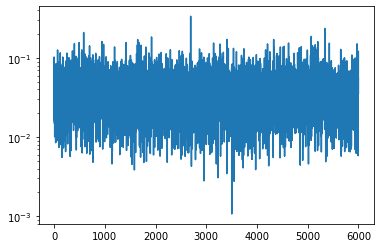

In [34]:
plt.semilogy(tr_features[:,-1])

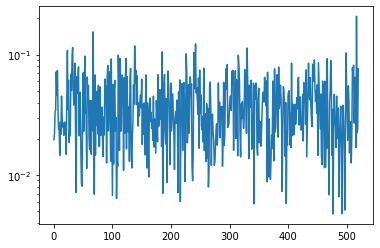

In [35]:
plt.semilogy(test_features[:,-1])

In [36]:
len(set(test_features[:,-1]))

521

### To obtain set of one hot codes for our labels

In [37]:
feat_tr = feat_all[0:tr_len,1:]
feat_test = feat_all[tr_len:tr_len+test_len,1:]

In [38]:
feat_test[:,-1] = [genre_set.index(w) for w in feat_test[:,-1]]
feat_tr[:,-1] = [genre_set.index(w) for w in feat_tr[:,-1]]

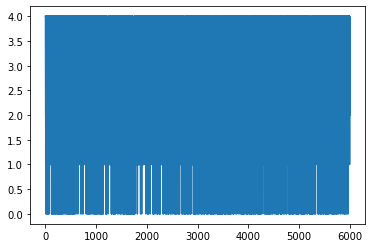

In [39]:
plt.plot(feat_tr[:,-1])

In [40]:
num_classes = len(genre_set)
one_hot = np.zeros((num_classes, num_classes*tr_len))
print(one_hot.shape)
for index_i, i in enumerate(feat_tr[:,-1]):
    one_hot[int(i),index_i] = 1


(5, 30000)


In [41]:
feat_tr[0:10,-1]

array([4, 4, 2, 4, 2, 2, 1, 3, 4, 2], dtype=object)

In [42]:
print(one_hot[:,0:10])
print(one_hot.shape)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 1. 1. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [1. 1. 0. 1. 0. 0. 0. 0. 1. 0.]]
(5, 30000)


## Dimension Reduction

Here there are a large number of features extracted so, data driven methods are used to reduce the dimension

### Using PCA for dimension reduction 

In [43]:
tr_features.shape

(6000, 518)

In [44]:
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA

In [45]:
pca = PCA(n_components=100, svd_solver='full')
#pca = KernelPCA(n_components=60, kernel='poly')

In [46]:
pca_obj = pca.fit(tr_features)

In [47]:
tr_features_red = pca_obj.transform(tr_features)

In [48]:
test_features_red = pca_obj.transform(test_features)

In [49]:
tr_features_red.shape

(6000, 100)

In [50]:
np.max(tr_features_red)

11349.55429387236

In [51]:
np.max(tr_features)

11025.0

In [52]:
scale_val = np.max(tr_features_red)/np.max(tr_features)

In [53]:
scale_val

1.0294380311902367

## Training Stage

### Setting up data 

In [54]:
x_train = tr_features_red/scale_val
x_test = test_features_red/scale_val
y_train = feat_tr[:,-1]
y_test = feat_test[:,-1]

In [55]:
class_set = list(range(num_classes))
class_lbl = [genre_set[i] for i in class_set]
class_name = [main_label_dict[genre_set[i]] for i in class_set]
label_dict = dict(zip(class_name,class_set))

In [56]:
label_dict

{'Pop': 0, 'Classical': 1, 'Rock': 2, 'Folk': 3, 'Hip-Hop': 4}

In [57]:
def plot_confusion_matrix(cm, classes,normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    #plt.figure(figsize=(8,8))
    plt.subplots()
    plt.imshow(cm, interpolation='nearest', cmap=cmap, aspect='auto')
    
    ax = plt.gca();

    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.gcf().subplots_adjust(bottom=0.15)
    ax.set_xticks(np.arange(len(classes)))
    ax.set_yticks(np.arange(len(classes)))
    ax.set_xticklabels(classes)
    ax.set_yticklabels(classes)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def one_hot_encoder(true_labels, num_records, num_classes):
    temp = np.array(true_labels[:num_records])
    true_labels1 = np.zeros((num_records, num_classes))
    #print(true_labels.shape)
    for index_i, i in enumerate(true_labels):
        #print(index_i,i)
        true_labels1[index_i,int(i)] = 1
    return true_labels1

def display_results(y_test, pred_probs, cm = True):
    pred = np.argmax(pred_probs, axis=-1)
    #print(pred)
    one_hot_true = one_hot_encoder(y_test, len(pred), num_classes)
    print('Test Set Accuracy =  {0:.2f}'.format(accuracy_score(y_test, pred)))
    print('Test Set F-score =  {0:.2f}'.format(f1_score(y_test, pred, average='macro')))
    print('ROC AUC = {0:.3f}'.format(roc_auc_score(y_true=one_hot_true, y_score=pred_probs, average='macro')))
    if cm:
        plot_confusion_matrix(confusion_matrix(y_test, pred), classes=label_dict.keys())

### Boosting

#### Without regularization

In [58]:
%%time
# Train

xgb_classifier = xgb.XGBClassifier(max_depth=5, learning_rate=0.1, objective='multi:softprob', \
                                   n_estimators=750, sub_sample = 0.9, num_class = num_classes)
xgb_classifier.fit(x_train, y_train)

# Predict
pred_probs = xgb_classifier.predict_proba(x_test)


Wall time: 2min 13s


In [59]:
pred = np.argmax(pred_probs, axis=-1)
print('Test Error: ',len(y_test[y_test!=pred])/len(y_test))

Test Error:  0.39539347408829173


Test Set Accuracy =  0.60
Test Set F-score =  0.56
ROC AUC = 0.816
Confusion matrix, without normalization
[[  9   0   9   1  16]
 [  0  33  12   1  21]
 [  1   7  74   5  42]
 [  0   1  13  43  34]
 [  1   5  29   8 156]]


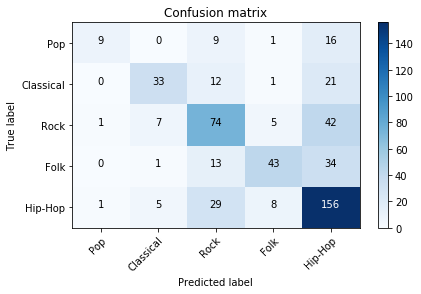

In [60]:
display_results(np.array(y_test,dtype=int), pred_probs)

####  With regularization

In [61]:
%%time
# Train

xgb_classifier = xgb.XGBClassifier(max_depth=5, learning_rate=0.1, objective='multi:softprob', \
                                   n_estimators=750, sub_sample = 0.9, num_class = num_classes, \
                                   reg_lambda=0.75,reg_alpha=0.9)
xgb_classifier.fit(x_train, y_train)

# Predict
pred_probs = xgb_classifier.predict_proba(x_test)


Wall time: 2min 10s


In [62]:
pred = np.argmax(pred_probs, axis=-1)
print('Test Error: ',len(y_test[y_test!=pred])/len(y_test))

Test Error:  0.3896353166986564


Test Set Accuracy =  0.61
Test Set F-score =  0.56
ROC AUC = 0.822
Confusion matrix, without normalization
[[  9   0  12   1  13]
 [  3  34  12   1  17]
 [  2   7  75   1  44]
 [  1   1  10  43  36]
 [  3   3  28   8 157]]


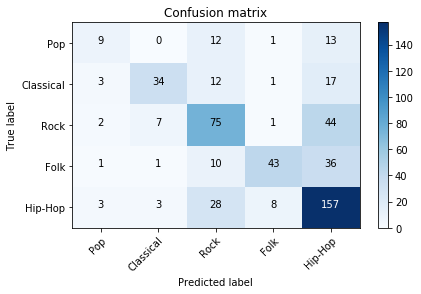

In [63]:
display_results(np.array(y_test,dtype=int), pred_probs)

### SVM 

In [64]:
cl_weight = dict(pd.Series(np.array(y_train,dtype=int)).value_counts(normalize=True))

In [65]:
cl_weight

{4: 0.3606666666666667,
 2: 0.26466666666666666,
 3: 0.18566666666666667,
 1: 0.11066666666666666,
 0: 0.07833333333333334}

In [66]:
x_train_svm = x_train/np.max(x_train)
x_test_svm = x_test/np.max(x_test)

In [67]:
%%time

# Train
svm_classifier = SVC(C=1400.0, probability = True, class_weight=cl_weight,gamma=8.5e-3)
svm_classifier.fit(x_train_svm, np.array(y_train,dtype=int))

# Predict
pred_probs = svm_classifier.predict_proba(x_test_svm)

Wall time: 22.8 s


In [68]:
pred = np.argmax(pred_probs, axis=-1)
print('Test Error: ',len(y_test[y_test!=pred])/len(y_test))

Test Error:  0.5662188099808061


Test Set Accuracy =  0.43
Test Set F-score =  0.32
ROC AUC = 0.695
Confusion matrix, without normalization
[[  2   4   4   2  23]
 [  0  21   9   3  34]
 [  1  13  23  18  74]
 [  0   4  11  28  48]
 [  7  11  18  11 152]]


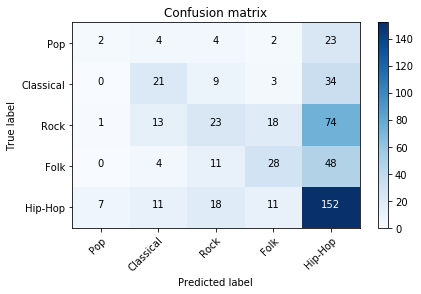

In [69]:
display_results(np.array(y_test,dtype=int), pred_probs)

### Random Forest

In [70]:
%%time
# Train
rf_classifier = RandomForestClassifier(n_estimators=500, min_samples_split=5)
rf_classifier.fit(x_train, np.array(y_train,dtype=int))

# Predict
pred_probs = rf_classifier.predict_proba(x_test)

Wall time: 16.6 s


Test Set Accuracy =  0.55
Test Set F-score =  0.41
ROC AUC = 0.817
Confusion matrix, without normalization
[[  1   0   4   0  30]
 [  0  14  13   0  40]
 [  0   0  58   0  71]
 [  0   1   7  31  52]
 [  1   1  12   0 185]]


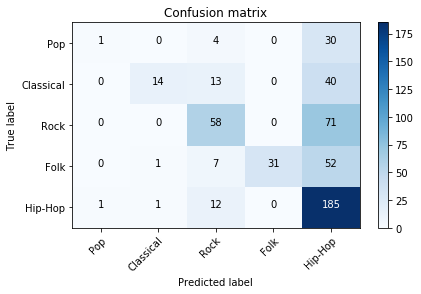

In [71]:
# Results
display_results(np.array(y_test,dtype=int), pred_probs)

### Logistic Regression

In [72]:
%%time
# Train
lr_classifier = LogisticRegression(penalty='l1')
lr_classifier.fit(x_train, np.array(y_train,dtype=int))

# Predict
pred_probs = lr_classifier.predict_proba(x_test)

G:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
G:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Wall time: 3.31 s


Test Set Accuracy =  0.52
Test Set F-score =  0.46
ROC AUC = 0.765
Confusion matrix, without normalization
[[ 10   2   8   4  11]
 [  4  26  18   2  17]
 [  5  12  57   8  47]
 [  2   6  15  31  37]
 [  4   6  30  11 148]]


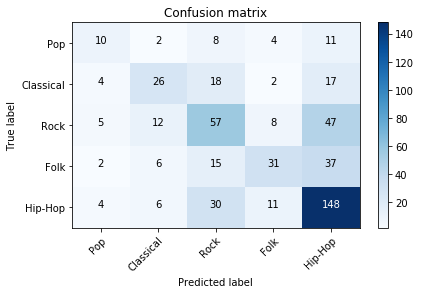

In [73]:
# Results
display_results(np.array(y_test,dtype=int), pred_probs)

### SNN

In [ ]:
x_train = x_train.T/np.max(abs(x_train))
print(x_train.shape)
x_test = x_test.T/np.max(abs(x_test))
print(x_test.shape)
print(y_train.shape)
y_train = y_train.T
print(y_train.shape)

In [ ]:
def label2onehot(lbl):
    d = np.zeros((lbl.max() + 1, lbl.size))
    d[lbl, np.arange(lbl.size)] = 1
    return d
def onehot2label(d):
    lbl = d.argmax(axis=0)
    return lbl


# turn labels into one hot
y_train.shape
print(type(y_train))
y_train = y_train.astype(int)
y_train_onehot = label2onehot(y_train)

def init_shallow(Ni, Nh, No):
    b1 = np.random.randn(Nh, 1) / np.sqrt((Ni+1.)/2.)
    W1 = np.random.randn(Nh, Ni) / np.sqrt((Ni+1.)/2.)
    b2 = np.random.randn(No, 1) / np.sqrt((Nh+1.))
    W2 = np.random.randn(No, Nh) / np.sqrt((Nh+1.))
    return W1, b1, W2, b2
Ni = x_train.shape[0]
Nh = 20
No = y_train_onehot.shape[0]
netinit = init_shallow(Ni, Nh, No)

print(y_train_onehot)

def softmax(a):
    a_max = np.zeros((1,60000))
    a_max = a.max(axis = 0)
    a_sane = a - a_max
    a_sane_exp = np.exp(a_sane)
    y = a_sane_exp/(a_sane_exp.sum(axis = 0))
    return y
def softmaxp(a,e):
    k = softmax(a)
    part1 = np.multiply(k,e)
    new = part1.sum(axis = 0)
    part2 = np.multiply(new.T,k)
    return(part1 - part2)
def relu(a):
    return(np.where(a>0,a,0))
def relup(a,e):
    a = np.where(a>0,1,0)
    return(a*e)
def forwardprop_shallow(x, net):
#     print(net)
    W1 = net[0]
    b1 = net[1]
    W2 = net[2]
    b2 = net[3]
#     print("Shape of W1 is ", W1.shape)
#     print(x.shape)
    Z1 = W1.dot(x) + b1
    a1 = relu(Z1)
    a2 = W2.dot(a1) + b2
    y = softmax(a2)
    return y
yinit = forwardprop_shallow(x_train, netinit)

def eval_loss(y, d):
    sum_vert = -np.log(y)*d
    return(sum_vert.sum()/y.shape[1])
print(eval_loss(yinit, y_train_onehot), 'should be around .26')

def eval_perfs(y, lbl):
    y_oneD = onehot2label(y)
    perf_par = (y_oneD != lbl)
    sum_perf_par = perf_par.sum()
    return (sum_perf_par/lbl.shape[0])*100
print(eval_perfs(yinit, y_train))

def update_shallow(x, d, net, gamma=.05):
    W1 = net[0]
    b1 = net[1]
    W2 = net[2]
    b2 = net[3]
    Ni = W1.shape[1]
    Nh = W1.shape[0]
    No = W2.shape[0]
    gamma = gamma / x.shape[1] # normalized by the training dataset size
    Z1 = W1.dot(x) + b1
    a1 = relu(Z1)
    a2 = W2.dot(a1) + b2
    y = softmax(a2)
    e2 = - d / y
    delta2 = softmaxp(a2,e2)
    e1 = W2.T.dot(delta2)
    delta1 = relup(a1, e1) 
    W2 = W2 - gamma * delta2.dot(a1.T)
    W1 = W1 - gamma * delta1.dot(x.T)
    b2 = b2 - gamma * delta2.sum(axis =1, keepdims = True )
    b1 = b1 - gamma * delta1.sum(axis =1, keepdims = True )
    return W1, b1, W2, b2

def backprop_shallow(x, d, net, T, gamma=.05):
    lbl = onehot2label(d)
    for t in range(T):
        net = update_shallow(x, d, net)
        #net = [W1,b1,W2,b2]
        y = forwardprop_shallow(x, net)
        loss = eval_loss(y, d)
        #print(loss)
        performance = eval_perfs(y, lbl)
        #print(performance)
    return net

nettrain_batch2 = backprop_shallow(x_train, y_train_onehot, netinit, 10000)

In [ ]:
print(x_test.shape)
print(y_test.shape)

y_test = y_test.astype(int)
y_test_onehot = label2onehot(y_test)

y_output = forwardprop_shallow(x_test, nettrain_batch2)

perf = eval_perfs(y_output, y_test)
print(perf)

display_results(np.array(y_test,dtype=int), y_output.T)